In [1]:
from diff_classifier import features as ft
from diff_classifier import heatmaps as hm
from diff_register import im_process as imp
from diff_classifier import aws
import pandas as pd
import skimage.io as sio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import xml.etree.ElementTree as et


## Trajectory Data

In [13]:
prefix = '100nm_S2_XY1_1'
fname = 'features_{}.csv'.format(prefix)
features = pd.read_csv(fname, index_col='Unnamed: 0')

In [14]:
features.head()

,AR,D_fit,MSD_ratio,Track_ID,X,Y,alpha,asymmetry1,asymmetry2,asymmetry3,boundedness,efficiency,elongation,fractal_dim,frames,kurtosis,straightness,trappedness
0,inf,1.207229e-02,1.333333,0.0,259.000000,1605.500000,5.917726e-10,1.000000,0.000000e+00,0.693147,0.250000,0.000000,1.000000,2.000000,5.0,2.500000,0.000000,-0.152585
1,1.515234e+00,1.476247e-02,inf,1.0,72.250000,1603.835009,1.344800e-08,0.927645,1.370192e-01,0.339719,0.185641,0.000000,0.340036,2.093743,27.0,3.224645,0.000000,-0.171368
2,inf,3.054402e-07,0.015139,2.0,26.500000,1537.000000,4.658679e+00,1.000000,0.000000e+00,0.693147,0.084104,0.628952,1.000000,1.757852,31.0,2.492293,0.230769,-0.201626
3,1.644980e+00,2.060917e-01,0.060289,3.0,219.829762,2036.956472,1.009922e+00,0.822548,2.209032e-01,0.227661,0.052553,0.382822,0.392090,1.790820,41.0,2.302929,0.128705,-0.211186
4,7.910484e+12,4.043864e-01,0.000000,4.0,218.742309,2033.992309,1.000000e+00,1.000000,-3.860791e-17,0.693147,1.000000,1.000000,1.000000,1.000000,3.0,1.500000,1.000000,0.045311


In [15]:
rfolder = 'Tissue_Studies/04_23_18_Registration_Test/tracking'
aws.download_s3('{}/{}.tif'.format(rfolder, prefix), '{}.tif'.format(prefix), bucket_name='ccurtis.data')

In [17]:
trim = sio.imread('{}.tif'.format(prefix))

(-0.5, 2047.5, 2043.5, -0.5)

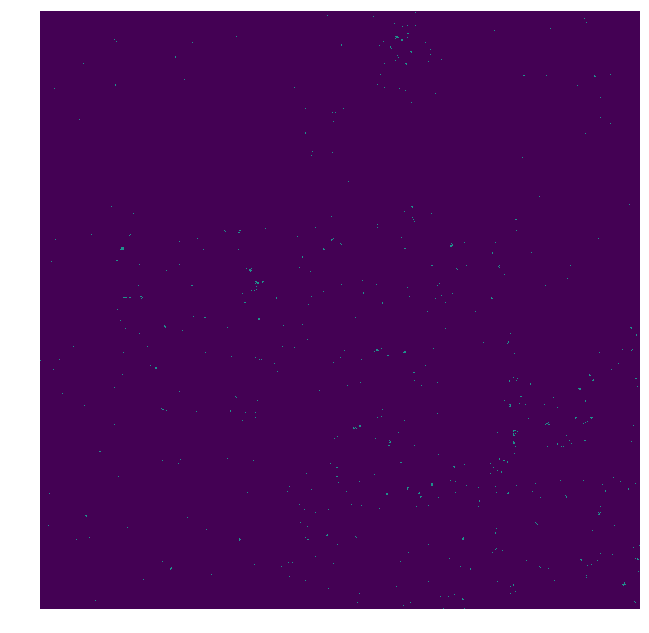

In [18]:
fig = plt.figure(figsize=(11, 11))
plt.imshow(trim[0, :, :]>0.1, vmin=0, vmax=2)
plt.axis('off')

/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:240: RuntimeWarning: invalid value encountered in less_equal
  zs = ma.masked_where(zs <= t_min, zs)
/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:241: RuntimeWarning: invalid value encountered in greater_equal
  zs = ma.masked_where(zs >= t_max, zs)


Plotted 100nm_S2_XY1_1 scatterplot successfully.


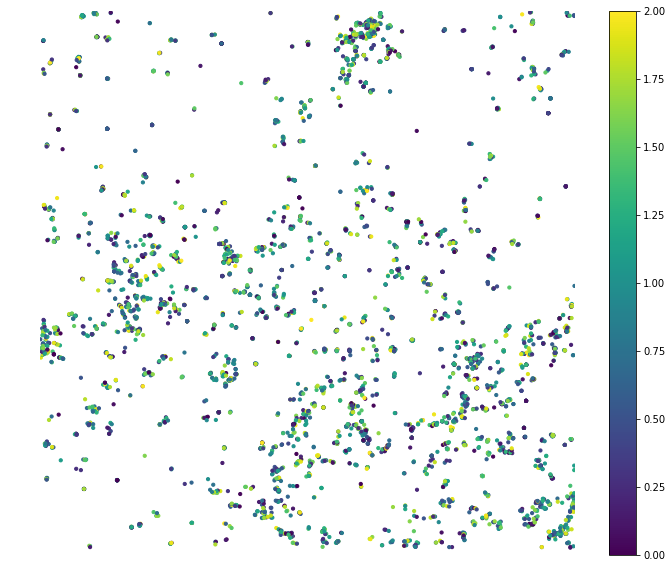

In [19]:
hm.plot_scatterplot(prefix, feature='AR', vmin=0, vmax=2, upload=False)

## Cell Data

In [2]:
cprefix = 'S1_NUC'
cfile = '{}.tif'.format(cprefix)
cfolder = 'Tissue_Studies/04_23_18_Registration_Test'

In [ ]:
#aws.download_s3('{}/{}'.format(cfolder, cfile), cfile, bucket_name='ccurtis.data')

In [3]:
cim = sio.imread(cfile)

In [ ]:
cim.shape

In [ ]:
ndim = 512
vpoint = (1500, 1600)
subim = cim[int(vpoint[0]-ndim/2):int(vpoint[0]+ndim/2), int(vpoint[1]-ndim/2):int(vpoint[1]+ndim/2)]

In [ ]:
subim.shape

In [4]:
xmlfile = 'multipoints_S2.xml'

def read_xmlpoints(xmlfile, converttopix = True, umppx=0.62, offset=(17000, -1460)):
    tree = et.parse(xmlfile)
    root = tree.getroot()

    y = []
    x = []
    xmlpoints = []
    counter = 0
    
    for point in root[0]:
        if counter > 1:
            x = float(point[2].attrib['value'])
            y = float(point[3].attrib['value'])
            if converttopix:
                xmlpoints.append(((x-offset[0])/umppx,(y-offset[1])/umppx))
            else:
                xmlpoints.append((x, y))
        counter = counter + 1

    return xmlpoints

In [5]:
xmlpoints = read_xmlpoints(xmlfile, converttopix=False)

In [6]:
def crop_to_videodims(cell_image, multichannel = False, vidpoint=(600, 600), defaultdims=True, dim=512, save=True,
                      fname='test.tif'):
    
    if defaultdims:
        ndim = 512
    else:
        ndim = dim

    if not multichannel:
        subim = cell_image[int(vidpoint[0]-ndim/2):int(vidpoint[0]+ndim/2), int(vidpoint[1]-ndim/2):int(vidpoint[1]+ndim/2)]

    if save:
        sio.imsave(fname, subim)
        
    return subim

In [20]:
prefix = 'DAPI'
cell_orig = '{}.tif'.format(prefix)
cell_bin = 'clean_{}.png'.format(prefix)
cell_cut = 'short_{}'.format(cell_bin)
call_skel = 'skel_{}'.format(cell_cut)

subim = crop_to_videodims(cim, vidpoint=(10000, 12000), defaultdims=False, dim=994, fname=cell_orig)

(-0.5, 993.5, 993.5, -0.5)

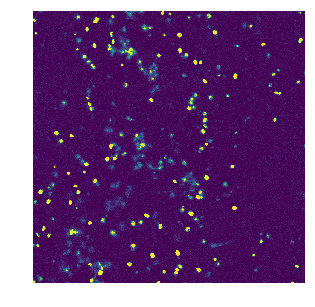

In [21]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(subim)
plt.axis('off')

/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


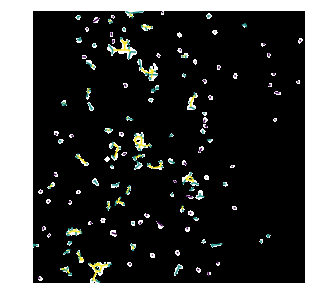

In [33]:
skeleton0, branch_data_short, nbranches, short_image, props = imp.skeleton_image('.', cell_orig, threshold=30, area_thresh=160, figsize=(5, 5), show=True, multichannel=False, channel=0,
                   disp_binary = True, default_name=True)
features = imp.mglia_features(props, branch_data_short, convert=True, umppx=0.33)

In [12]:
features

,X,Y,area,average_branch,eccentricity,inertia_tensor,label,main_branch,moments,perimeter,solidity,total_branches
0,4.645161,252.709677,62.0,8.414214,0.861264,"[[3.01248699272, -1.60665972945], [-1.60665972...",1,8.414214,"[[62.0, 288.0, 1954.0, 15318.0], [230.0, 1168....",30.485281,0.953846,1
1,30.955224,253.626866,67.0,19.656854,0.971742,"[[1.39808420584, 0.897304522165], [0.897304522...",2,19.656854,"[[67.0, 667.0, 8277.0, 113473.0], [176.0, 1692...",41.313708,0.943662,1
2,60.982143,105.285714,56.0,2.414214,0.653333,"[[3.88265306122, -0.987244897959], [-0.9872448...",5,2.414214,"[[56.0, 223.0, 1195.0, 7255.0], [184.0, 788.0,...",26.313708,0.949153,1
3,70.273684,249.957895,190.0,12.071068,0.713109,"[[11.2929639889, -1.54310249307], [-1.54310249...",6,12.071068,"[[190.0, 1762.0, 20584.0, 270802.0], [1322.0, ...",53.213203,0.954774,1
4,107.684514,20.885435,1737.0,10.933771,0.829201,"[[108.513645076, -42.570073801], [-42.57007380...",7,31.372092,"[[1737.0, 56773.0, 2396345.0, 113644123.0], [3...",284.444697,0.762511,15
5,85.364341,137.116279,129.0,1.000000,0.482717,"[[11.947719488, -0.376239408689], [-0.37623940...",8,1.000000,"[[129.0, 821.0, 6419.0, 55895.0], [918.0, 5891...",41.798990,0.928058,1
6,122.637500,57.150000,80.0,4.999194,0.693339,"[[9.8525, -1.379375], [-1.379375, 5.75609375]]",9,8.304193,"[[80.0, 371.0, 2181.0, 14153.0], [492.0, 2392....",39.142136,0.776699,4
7,136.478827,244.289902,307.0,25.313708,0.832993,"[[28.5250771891, 17.2919076064], [17.291907606...",11,25.313708,"[[307.0, 3217.0, 46039.0, 777049.0], [3159.0, ...",82.284271,0.814324,1
8,160.506098,29.554878,164.0,16.071068,0.893300,"[[31.9543054729, 2.54911511005], [2.5491151100...",13,16.071068,"[[164.0, 903.0, 6081.0, 45561.0], [1895.0, 100...",61.455844,0.815920,1
9,165.709302,112.744186,86.0,12.656854,0.732512,"[[5.46944294213, 1.51622498648], [1.5162249864...",14,12.656854,"[[86.0, 577.0, 4771.0, 43369.0], [408.0, 2607....",37.384776,0.851485,1
